In [ ]:
import sys
sys.path.append( "/home/ljuusola/Projects/RL/SuttonBarto" )

from bandits.rewards import ConstantRewardGenerator, NormalNoiseRewardGenerator, ValueNoiseRewardGenerator, BrownianMotionRewardGenerator
from bandits.policies import EpsilonGreedyPolicy
from bandits.policies import BTSampleMean, BTEMAConst, BTEMA
from bandits.karm import KArmedBandit

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)

MAX_PRINT_TRIALS = 5
n_trials = 2000
k = 10
len_trial = 1000

alpha = .1
epsilon = .1
policiesBase = {
    "sm":  EpsilonGreedyPolicy( epsilon, BTSampleMean(k) ),
    "emaConst": EpsilonGreedyPolicy( epsilon, BTEMAConst(k, epsilon) ),
    "ema": EpsilonGreedyPolicy( epsilon, BTEMA(k, epsilon) ),
}

policyNames = list( sorted( set( policiesBase.keys() ) ) )
nPolicies = len( policyNames )

rewardMeansExp = np.random.normal( 0, 1, size=(n_trials, k) )
rewardPathsExp = np.zeros( ( n_trials, len_trial, nPolicies ) )
optimlPathsExp = np.zeros( ( n_trials, len_trial, nPolicies ) )
for itrial in range( n_trials ):
    rewardMeans = rewardMeansExp[itrial]
    rewardGenerators = [ ValueNoiseRewardGenerator(
                            valueGen=BrownianMotionRewardGenerator(0.01),
                            # noiseGen=ConstantRewardGenerator(0.0),
                            noiseGen=NormalNoiseRewardGenerator(0,1),
                        ) for rm in rewardMeans ]
    bandit = KArmedBandit( rewardGenerators )
    policies = deepcopy( policiesBase )
    curRewards = np.zeros( nPolicies )
    curChoices = np.zeros( nPolicies )
    if n_trials <= MAX_PRINT_TRIALS:
        print( np.array( [ r.get_value() for r in bandit.rewards ] ) )
    for i in range(len_trial):
        optimalArm = bandit.optimal_arm()
        for ipol, name in enumerate(policyNames):
            policy = policies[name]
            arm = policy.choice()
            reward = bandit.query_arm( arm )
            policy.update( arm, reward )
            curRewards[ipol] = reward
            curChoices[ipol] = arm
        bandit.step()
        curChoicesBool = curChoices == optimalArm

        rewardPathsExp[itrial,i,:] = curRewards
        optimlPathsExp[itrial,i,:] = curChoicesBool.astype(float)

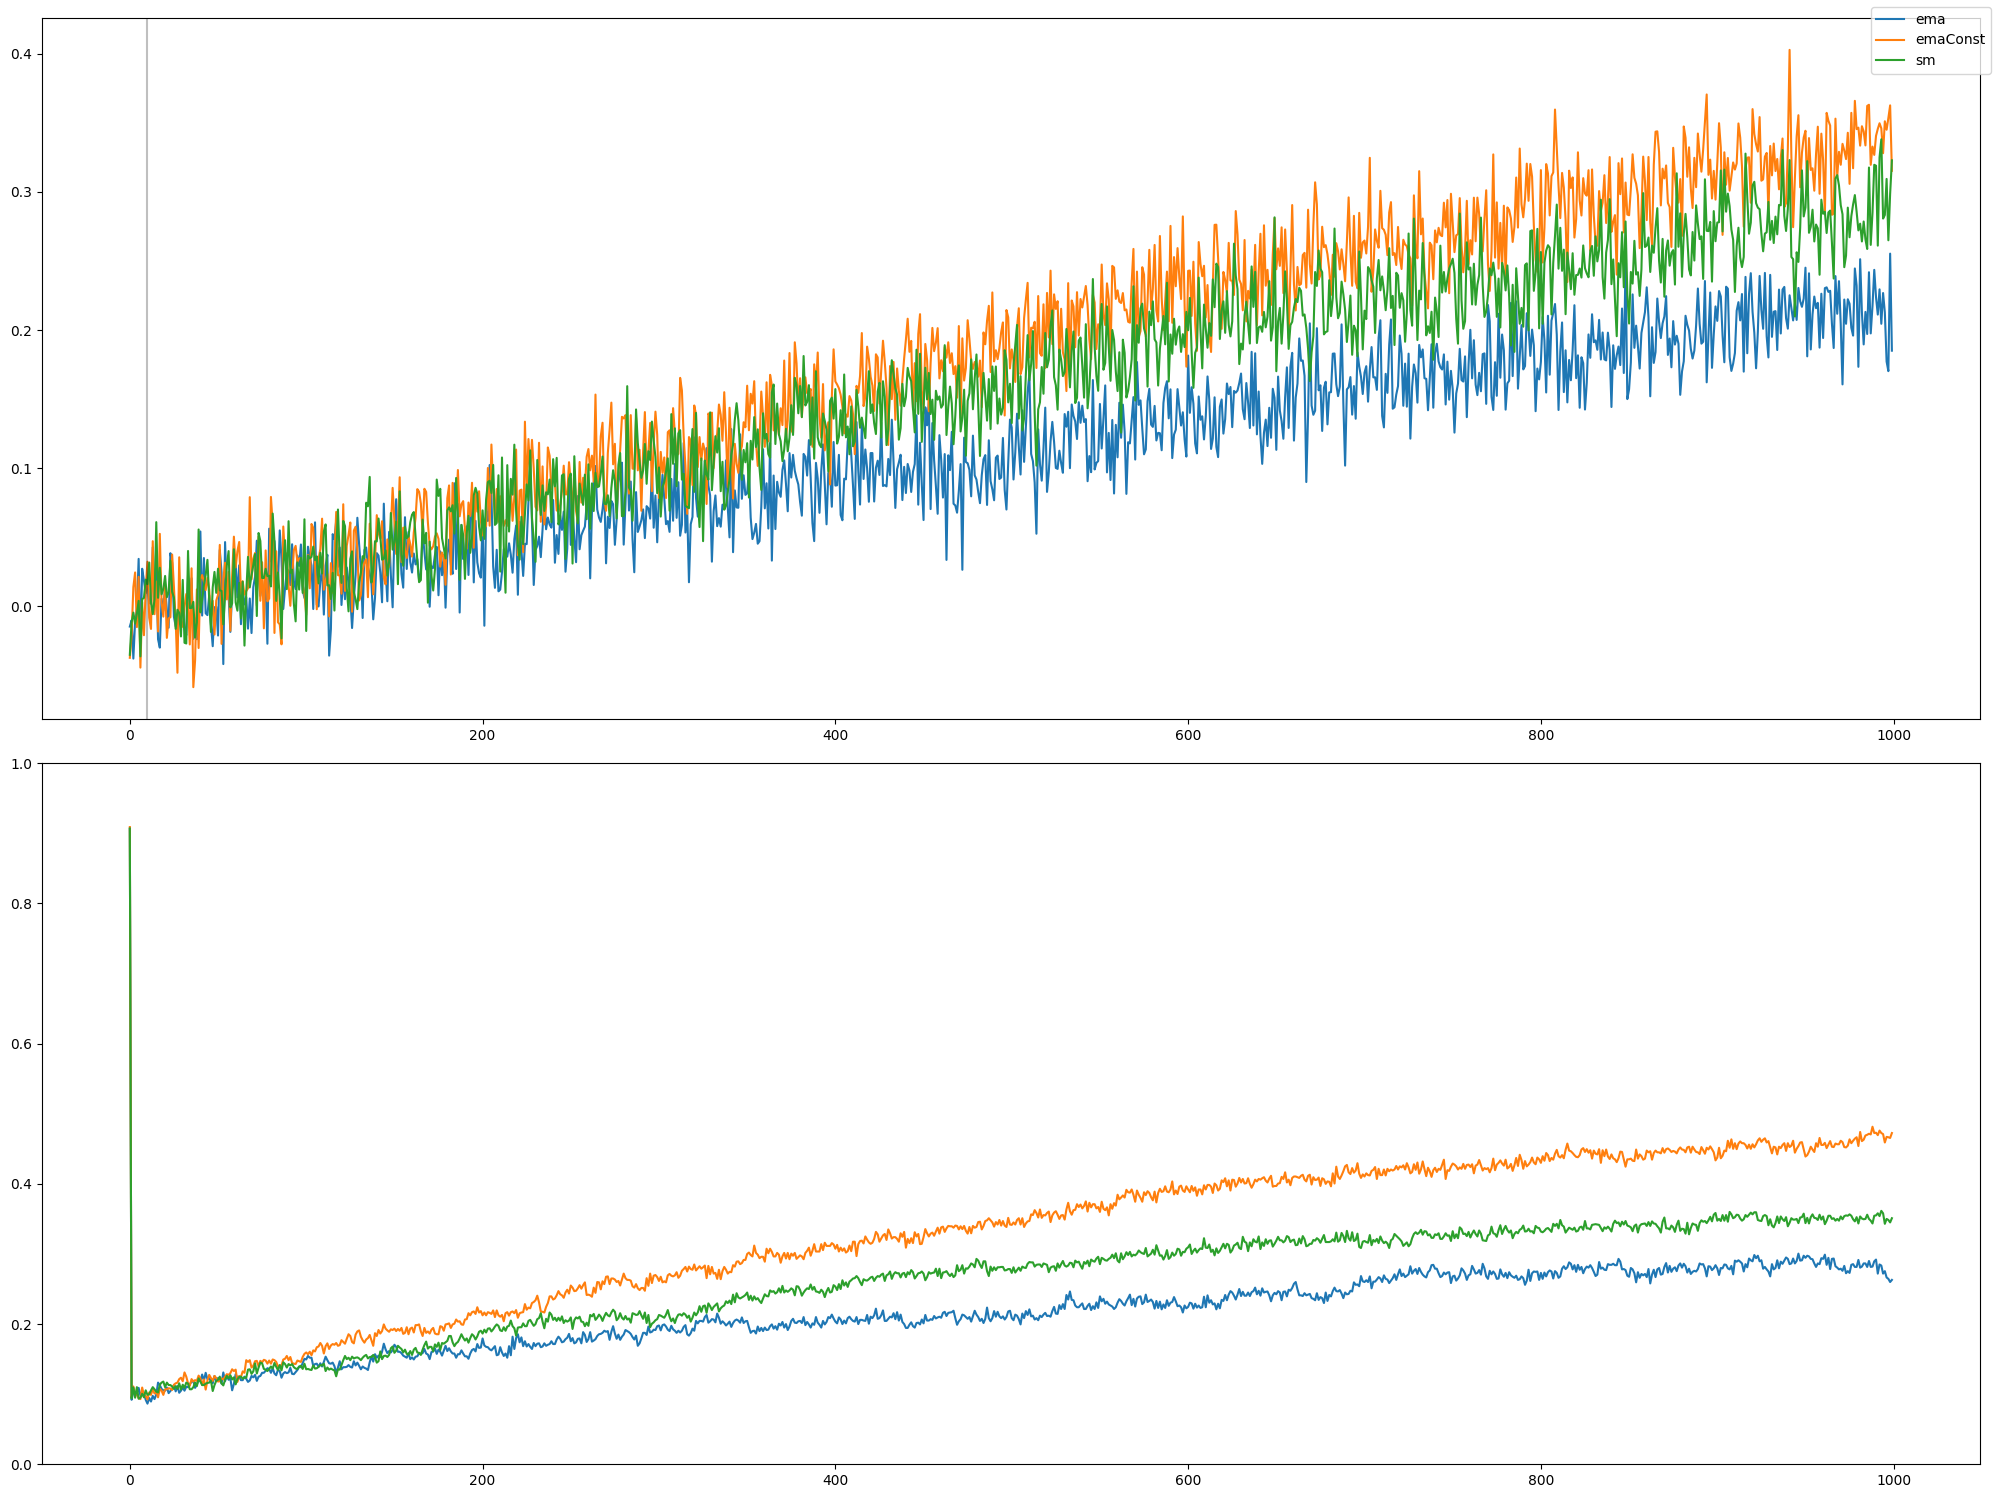

In [4]:
fig, axs = plt.subplots( nrows = 2 )
for ipol, name in enumerate( policyNames ):
    rewards = rewardPathsExp[:, :, ipol].mean(axis = 0)
    optfrac = optimlPathsExp[:, :, ipol].mean(axis = 0)
    axs[0].plot( rewards, label=name )
    axs[1].plot( optfrac )

axs[0].axvline( k, color = "black", alpha = .25 )
axs[1].set_ybound(0, 1)

fig.tight_layout()
fig.legend()

plt.show()